In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events,get_events
from functions import perform_chisq, dc_params_nsi, dc_params
from DC.event_processing import list_of_params_nsi, return_precomputed_nsi, get_deltachi, to_hist
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [4]:
ndim = 3
pid = 0
livetime = 2.45*365*24*3600 #Effective livetime table1 DC2019
precomputed_events = True
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(-1e-1,1e-1,20)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(0,0,1)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(pid,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

FileNotFoundError: Pee 3gen for pid 0, dm=0.93, s24=0.0, e_mm=-0.1,e_mt=0.0, not found

In [5]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    data_H1 = [(p, pid,True) for p in param_list]
    data_H0 = [(Ebin,zbin,param_list[0],pid,False,False) for Ebin in range(8) for zbin in range(8)]
    p = Pool()
    H1_events_list = p.starmap(get_all_events, data_H1)
    H0_events = p.starmap(get_events, data_H0)
    p.close()
    H0_events = np.array(H0_events).reshape(8,8)
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    pickle.dump(H0_events,open(f'./pre_computed/H0_DC_{pid}.p','wb'))


H1_list = [pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb')) for pid in [0,1]]

H1 = np.array(H1_list)*livetime
H0 = np.array(H0_list)*livetime
H1 = np.swapaxes(H1,0,1)

'''
no_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])
no_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])
H0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])
events = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])
background = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])
best_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017

data = np.sum(events,axis=2)

H0_factors = H0_paper / np.sum(H0,axis=2)
noosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axis=2)*livetime) #can laos use best_fit_contamination here

# Normalize NSI hypothesis
H1_nonorm = H1 #No normalization
H1_norm_H0 = H1 * H0_factors[None,:,None,:] #Norm against H0
H1_norm_noosc = H1*noosc_factors[None,:,None,:] # Norm against no oscillation
'''

"\nno_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])\nno_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])\nH0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])\nevents = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])\nbackground = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])\nbest_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017\n\ndata = np.sum(events,axis=2)\n\nH0_factors = H0_paper / np.sum(H0,axis=2)\nnoosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axi

In [6]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
norm_factor = np.array([0.9,0.9])
back_factor = np.array([0.15,1])
for pid in [0,1]:
    ax[0,pid].step(Ebins_2018, to_hist(no_osc_paper[pid]), color = 'blue', ls = '--', alpha = 0.6, label='DC no osc.', where='post')
    ax[0,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(no_osc[pid],axis=1)*livetime + back_factor[pid]*np.sum(background[pid],axis=1)), color = 'green', ls='--', alpha=0.6, label='Me no osc.', where='post')
    ax[0,pid].set_xscale('log')
    ax[1,pid].step(Ebins_2018, to_hist(H0_paper[pid]), color = 'blue', label=r'DC $3\nu$', where='post')
    ax[1,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(H0[pid],axis=1)), color = 'green', label=r'Me $3\nu$', where='post')
    ax[1,pid].set_xscale('log')

ax[0,0].set_title('Cascades',fontsize=20)
ax[0,1].set_title('Tracks',fontsize=20)
ax[1,0].set_xlabel('E [GeV]')
ax[1,1].set_xlabel('E [GeV]')
ax[0,0].legend()
ax[1,0].legend()
fig.tight_layout()

NameError: name 'no_osc' is not defined

In [6]:
sigma_a = 0.25
sigma_b = 0.04
f = 0
chisq,  best_fit_index, min_chi2 = get_deltachi([H for H in H1],emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1,1,0])
deltachi = (chisq - chisq.min())
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
#best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

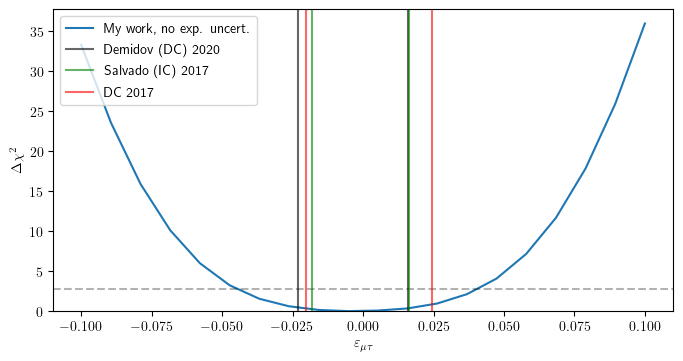

In [8]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, deltachi,label='My work, no exp. uncert.')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label='Demidov (DC) 2020')
plt.axvline(demidov[1], alpha=0.6,c='black')

plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (IC) 2017')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()

In [ ]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, deltachi,label='My work, no exp. uncert.')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label='Demidov (DC) 2020')
plt.axvline(demidov[1], alpha=0.6,c='black')

plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (IC) 2017')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\mu}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.title('DC')
plt.legend()

Text(0.5, 1.0, 'Tracks')

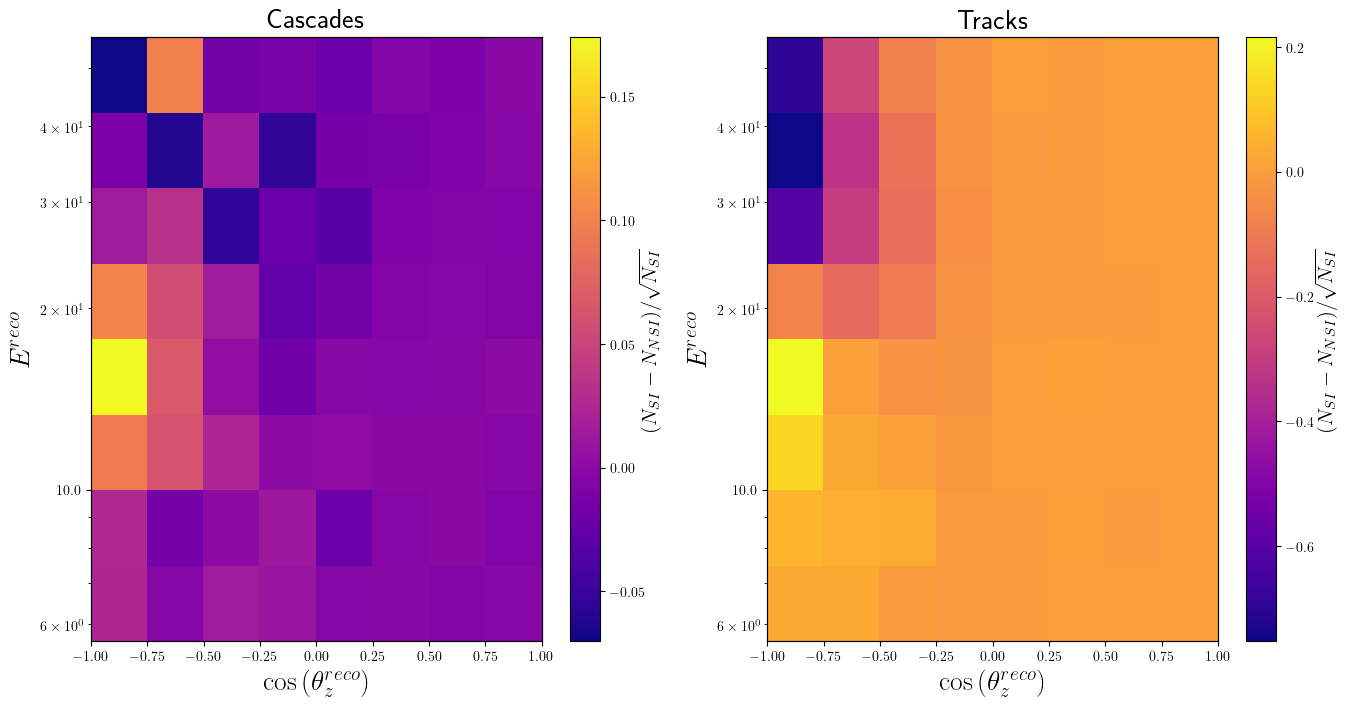

In [83]:
N_NSI_left = H1[0]
N_NSI_right = H1[-1]
N_SI = H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_max = (N_SI - N_NSI_right)/np.sqrt(N_SI)

fig, ax = plt.subplots(1,2,figsize=(16,8))
for pid in [0,1]:
    im = ax[pid].pcolormesh(zbins_2018,Ebins_2018, pull_min[pid], cmap='plasma')
    ax[pid].set_yscale('log')
    plt.colorbar(im, ax=ax[pid])
    ax[pid].set_ylabel(r'$E^{reco}$', fontsize=20)
    ax2 = ax[pid].twinx()
    #ax[pid].yaxis.set_label_position("right")
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=15, labelpad= 70)
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].ticklabel_format(style='plain',axis='y')
    #ax[pid].set_yticks(Ebins_2018)
    ax2.set_yticks([])
ax[0].set_title('Cascades', fontsize=20)
ax[1].set_title('Tracks', fontsize=20)
#c = fig.colorbar()

In [ ]:
old = h5py.File(f'./pre_computed/PINGU/E0z0.hdf5', 'r')
new = h5py.File(f'./pre_computed/PINGU/E6z6.hdf5', 'a')
try:
    dset = f.create_dataset(f'{ndim}gen/P{flavor_from}{flavor_to}/{pid}/{hashed_param_name}', data=prob, chunks=True)
    for key in param_dict.keys():
        dset.attrs[key] = param_dict[key]
    f.close()
except RuntimeError:
    if overwrite:
        dset = f[f'{ndim}gen/P{flavor_from}{flavor_to}/{pid}/{hashed_param_name}']
        dset[...] = prob
    else:
        print(f'{ndim}gen/P{flavor_from}{flavor_to}/{pid}/{hashed_param_name} already exists, skipping')
    f.close()
    return prob
if E_bin == 5 and z_bin == 5 and flavor_from == 'am' and flavor_to == 'am' and pid==1:
    with open(f'./pre_computed/PINGU/hashed_params.csv','a') as fd:
        fd.write(f'{param_dict};{hashed_param_name}\n')
return prob

In [33]:
def merge_h5(colab,Ebin,zbin,Ndim,flavor_from,flavor_to,anti,pid):
    if anti:
        flavor_from = 'a' + flavor_from
        flavor_to = 'a' + flavor_to
    with h5py.File(f'./pre_computed/{colab}/E{Ebin}z{zbin}.hdf5', 'r') as read:
        with h5py.File(f'./pre_computed/new/{colab}/E{Ebin}z{zbin}.hdf5', 'a') as write:
            for param in read[f'{Ndim}gen/P{flavor_from}{flavor_to}/{pid}/'].keys():
                path = f'{Ndim}gen/P{flavor_from}{flavor_to}/{pid}/'+param
                array = read[path][:]
                try:
                    dset = write.create_dataset(path, data=array)
                except RuntimeError:
                    pass # Don't update
                for key in read[path].attrs:
                    write[path].attrs[key] = read[path].attrs[key]
merge_h5('PINGU',0,0,3,'m','m',False,0)